In [184]:
import torch 

import pyro
from pyro import distributions as dist
from pyro.infer import Predictive, config_enumerate

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import logging

In [375]:
@config_enumerate
def model(A_obs=None, B_obs=None):
    A_priors = pyro.sample('A_priors', dist.Dirichlet(torch.ones(2)).to_event())
    beta = pyro.sample("beta_dist", dist.Beta(torch.tensor([5., 5.]), torch.tensor([5., 5.])).to_event())
    N = 1 if A_obs is None else len(A_obs)
    with pyro.plate("N", N):
        A = pyro.sample('A', dist.Categorical(probs=A_priors), obs=A_obs, infer={'enumerate': 'parallel'})
        B = pyro.sample("B", dist.Bernoulli(beta[..., A.long()]), obs=B_obs)
        return A, B

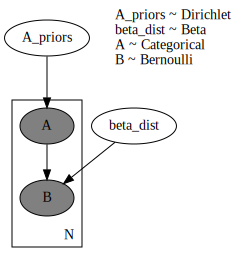

In [369]:
A_obs = torch.ones(10)
B_obs = torch.ones(10)
pyro.render_model(model, model_args=(A_obs, B_obs), render_params=True, render_distributions=True)

## Prior Predictive Distributions

In [351]:
prior_predictive_samples = Predictive(model, posterior_samples={}, num_samples=5000)()

In [352]:
prior_predictions = pd.DataFrame({
    'prior_class_0': prior_predictive_samples['A_priors'][:, 0, 0],
    'prior_class_1': prior_predictive_samples['A_priors'][:, 0, 1],
    'beta_dist_conc_0': prior_predictive_samples['beta_dist'][:, 0, 0],
    'beta_dist_conc_1': prior_predictive_samples['beta_dist'][:, 0, 1],
    'A': prior_predictive_samples['A'][:, 0],
    'B': prior_predictive_samples['B'][:, 0],
})

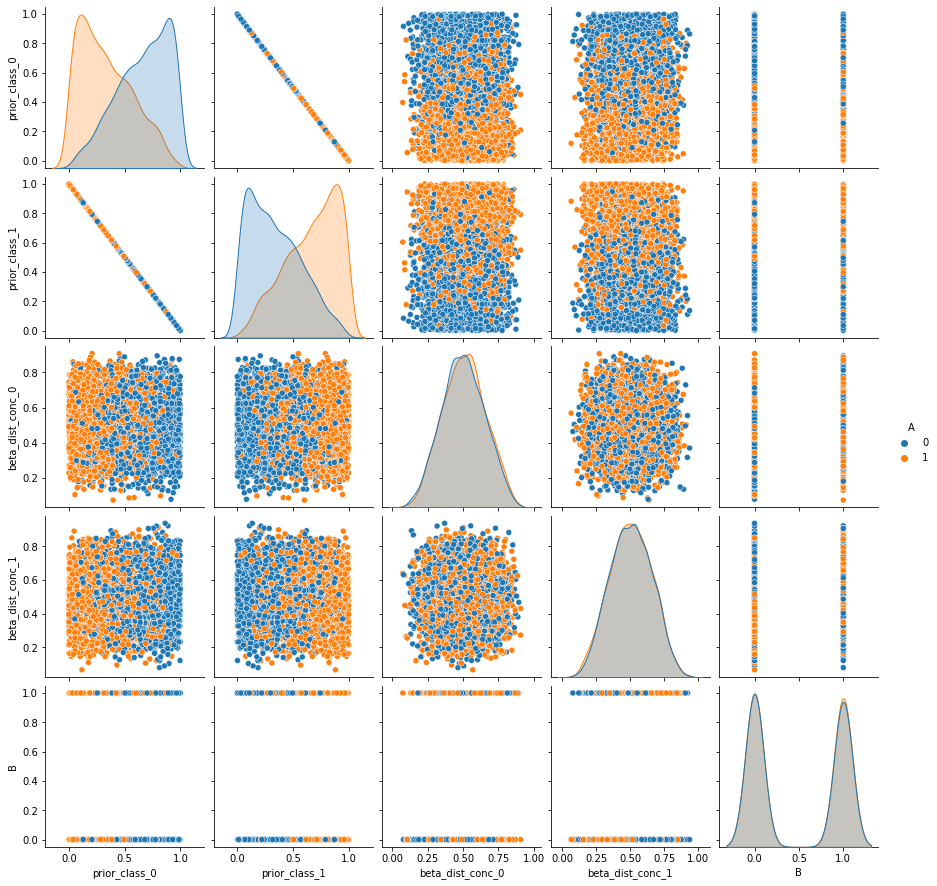

In [353]:
sns.pairplot(data=prior_predictions, hue='A')

## Conditioned Predictive Destribution

In [354]:
params = {
    'A_priors': torch.tensor([0.2, 0.8]),
#     'beta_dist': torch.tensor([[1., 1.],
#                                [1., 1.]], dtype=float)
    'beta_dist': torch.tensor([0.9, 0.1]),
}
conditioned_model = pyro.poutine.condition(model, data=params, )

In [355]:
conditioned_predictive_samples = Predictive(conditioned_model, posterior_samples={}, num_samples=5000)()

In [356]:
conditioned_predictions = pd.DataFrame({
    'prior_class_0': conditioned_predictive_samples['A_priors'][:, 0, 0],
    'prior_class_1': conditioned_predictive_samples['A_priors'][:, 0, 1],
    'beta_dist_conc_0': conditioned_predictive_samples['beta_dist'][:, 0, 0],
    'beta_dist_conc_1': conditioned_predictive_samples['beta_dist'][:, 0, 1],
    'A': conditioned_predictive_samples['A'][:, 0],
    'B': conditioned_predictive_samples['B'][:, 0],
})

In [357]:
conditioned_predictions.head()

,prior_class_0,prior_class_1,beta_dist_conc_0,beta_dist_conc_1,A,B
0,0.2,0.8,0.9,0.1,1,0.0
1,0.2,0.8,0.9,0.1,1,0.0
2,0.2,0.8,0.9,0.1,0,1.0
3,0.2,0.8,0.9,0.1,1,0.0
4,0.2,0.8,0.9,0.1,1,0.0


<AxesSubplot:xlabel='B', ylabel='Count'>

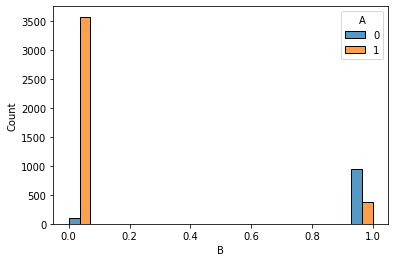

In [358]:
sns.histplot(data=conditioned_predictions, x='B', hue='A', multiple='dodge')

## Model Training

In [410]:
A_obs = conditioned_predictive_samples['A'].squeeze()
B_obs = conditioned_predictive_samples['B'].squeeze()

CPU times: user 5.22 s, sys: 169 ms, total: 5.39 s
Wall time: 5.35 s


Text(0, 0.5, 'ELBO loss')

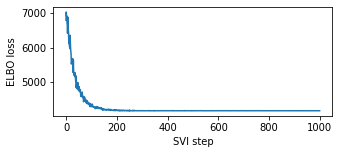

In [411]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.TraceEnum_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(A_obs, B_obs)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

## Variational DistribCheck

In [412]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.A_priors [-1.3146368]
AutoNormal.scales.A_priors [0.03823726]
AutoNormal.locs.beta_dist [ 2.2284927 -2.225411 ]
AutoNormal.scales.beta_dist [0.10012793 0.05517152]


In [413]:
with pyro.plate("samples", 1000, dim=-1):
    guide_samples = auto_guide()

In [414]:
import seaborn as sns

variational_distribution = pd.DataFrame({
    'A_class_0': guide_samples['A_priors'][:, 0].detach().numpy(),
    'A_class_1': guide_samples['A_priors'][:, 1].detach().numpy(),
    'bernoulli_class_0': guide_samples['beta_dist'][:, 0].detach().numpy(),
    'bernoulli_class_1': guide_samples['beta_dist'][:, 1].detach().numpy(),
})

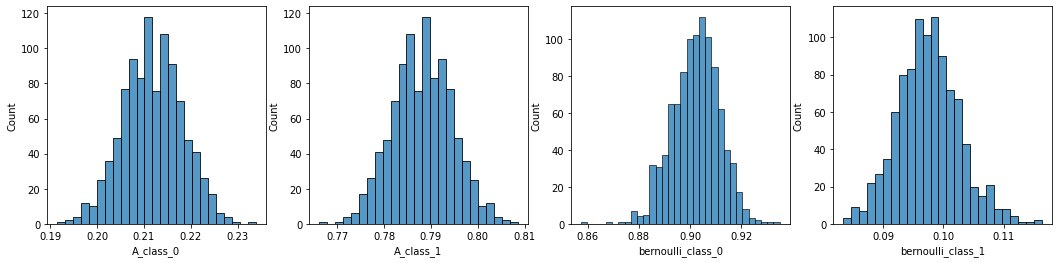

In [415]:
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
for ax, col in zip(axs, ['A_class_0', 'A_class_1', 'bernoulli_class_0', 'bernoulli_class_1']):
    sns.histplot(data=variational_distribution, x=col, ax=ax)

## Posterior Predictive Check

In [ ]:
n_samples = len(A_obs)
n_replicates = int(20)

predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=n_samples)

A_sum, B_sum = [], []
for replicate in range(n_replicates):
    svi_samples = predictive()
    A_sum.append(svi_samples['A'].sum(0))
    B_sum.append(svi_samples['B'].sum(0))

In [ ]:
import numpy as np

posterior_predictions = pd.DataFrame({
    'A_sum': torch.tensor(A_sum).squeeze().int(),
    'B_sum': torch.tensor(B_sum).squeeze().int(),
}) 

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(data=posterior_predictions, x='A_sum', ax=axs[0])
axs[0].axvline(A_obs.sum(), c='red')

sns.histplot(data=posterior_predictions, x='B_sum', ax=axs[1])
axs[1].axvline(B_obs.sum(), c='red')

In [409]:
B_obs

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])